遇到一个坑，也不知道是交叉熵损失函数还是什么，一开始不收敛，后来不知道做了什么可以了，依稀记得分类损失没用自带交叉熵，然后为了弄懂为什么，就又改了，并且忘了成功的时候是怎么做的。。最后改过之后，lsgan可以，其他都不行。。。醉了。。  
这个先当废案吧，我再重新实现一下。。。  
上面删掉。。找到原因了，python换行要加\，不加虽然不报错，但是实际没加上。。。吐了

In [1]:
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt 
import os 
import torchvision.transforms as trans 
from PIL import Image 

# Data

In [2]:
mode = 'rsgan' # 'gan', 'lsgan', 'rsgan'

path_train = "/home/wwang/datasets/mnist/train/"
path_test = "/home/wwang/datasets/mnist/test/"
channel_d = 64
channel_g = 64
latent_dim = 100
device = T.device("cuda:0")
path_work = "/home/wwang/wwgeneration/work/acgan/"
num_class = 10
step_g = 1
epochs = 10
learning_rate_g = 2e-4
learning_rate_d = 2e-4
batch_size = 128
num_workers = 2
λ_cls = 10

In [3]:
class Dataset_acgan(Dataset):
    #
    def __init__(self, path=path_train):
        names = os.listdir(path)
        names.sort()
        labels = [i for i in range(len(names))]
        names_to_labels = dict(zip(names, labels))
        labels_to_names = dict(zip(labels, names))
        list_image = []
        list_label = []
        for name in names:
            list_c = os.listdir(path + name)
            for path_image in list_c:
                list_image.append(path + name + '/' + path_image)
                list_label.append(names_to_labels[name])
        self.list_image = list_image
        self.list_label = list_label
        self.eye = T.eye(len(names))
        self.transform = trans.Compose([trans.ToTensor(),
                                        trans.Normalize((0.5), (0.5))
                                        ])
    #
    def __getitem__(self, idx):
        image = Image.open(self.list_image[idx])
        image = self.transform(image)
        label = self.eye[self.list_label[idx]].reshape([-1,1,1])
        return image, label
    #
    def __len__(self):
        return len(self.list_image)

/home/wwang/anaconda3/envs/pytorch/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


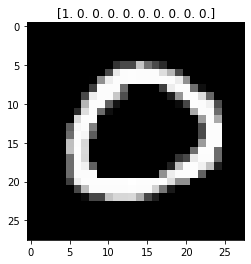

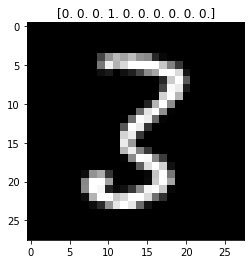

In [4]:
dataloader = DataLoader(Dataset_acgan(), batch_size=1, shuffle=True)
n = 0
for image, label in dataloader:
    if n >= 2:
        break
    n += 1
    image = image.numpy().squeeze() * 0.5 + 0.5
    plt.imshow(image, 'gray')
    plt.title(label.numpy().squeeze())
    plt.show()

# Network Structure

In [5]:
class Discriminator(nn.Module):
    #
    def __init__(self, channel=channel_d, num_class=num_class):
        super().__init__()
        self.num_class = num_class
        self.layers = nn.Sequential(
            nn.Conv2d(1, channel, 4, 2, 1),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU(),
            nn.Conv2d(channel, channel*2, 4, 2, 1),
            nn.BatchNorm2d(channel*2),
            nn.LeakyReLU(),
            nn.Conv2d(channel*2, channel*4, 3, 1, 0),
            nn.BatchNorm2d(channel*4),
            nn.LeakyReLU(),
            nn.Conv2d(channel*4, channel*8, 3, 1, 0),
            nn.BatchNorm2d(channel*8),
            nn.LeakyReLU()
        )
        self.D_src = nn.Conv2d(channel*8, 1, 3, 1, 0)
        self.D_cls = nn.Conv2d(channel*8, num_class, 3, 1, 0)
    #
    def forward(self, x):
        x = self.layers(x)
        src = self.D_src(x)
        cls = self.D_cls(x)
        return src, cls

In [6]:
class Generator(nn.Module):
    #
    def __init__(self, channel=channel_g, latent_dim=latent_dim, num_class=num_class):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(latent_dim+num_class, channel*8, 3, 1, 0),
            nn.BatchNorm2d(channel*8),
            nn.ReLU(),
            nn.ConvTranspose2d(channel*8, channel*4, 3, 1, 0),
            nn.BatchNorm2d(channel*4),
            nn.ReLU(),
            nn.ConvTranspose2d(channel*4, channel*2, 3, 1, 0),
            nn.BatchNorm2d(channel*2),
            nn.ReLU(),
            nn.ConvTranspose2d(channel*2, channel, 4, 2, 1),
            nn.BatchNorm2d(channel),
            nn.ReLU(),
            nn.ConvTranspose2d(channel, 1, 4, 2, 1),
            nn.Tanh()
        )
    #
    def forward(self, noise, label):
        x = T.cat([noise, label], 1)
        return self.layers(x)

# Show

In [7]:
@T.no_grad()
def show(GG=None):
    #
    if GG==None:
        GG = Generator().to(device)
    GG.eval()
    #
    plt.figure(figsize=(16, 8))
    gs = plt.GridSpec(10, 20)
    gs.update(wspace=0.05, hspace=0.05)
    n = 0
    z = T.randn([20,100,1,1]).to(device)
    for i in range(10):
        L = T.zeros([20,10,1,1]).to(device)
        L[:,i,:,:] = 1 
        images = GG(z,L).cpu().numpy().reshape([-1,28,28]).transpose([1,2,0]) * 0.5 + 0.5
        for j in range(20):
            ax = plt.subplot(gs[n])
            n += 1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(images[:,:,j], 'gray')   
    plt.show()

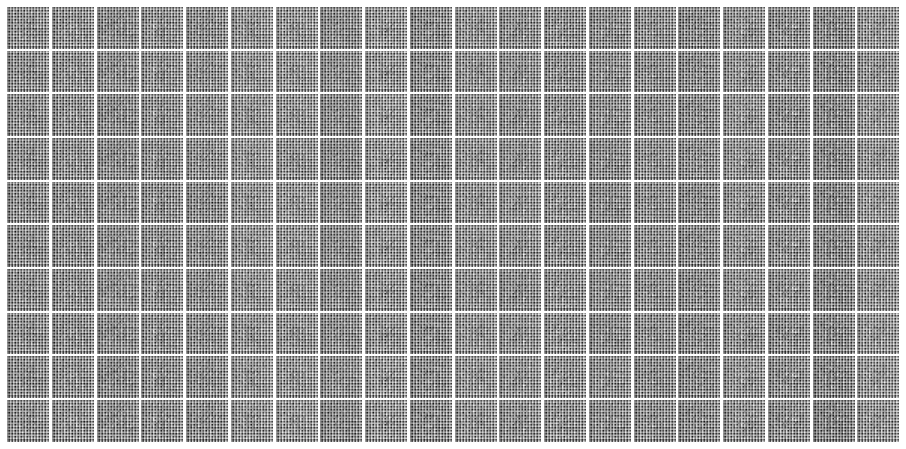

In [8]:
show()

# Train

In [9]:
def trainer_d(net_d, optimizer_d, net_g, image_real, label):
    #
    src_real, cls_real = net_d(image_real)
    image_fake = net_g(T.randn([image_real.shape[0], latent_dim, 1, 1]).to(device), label)
    src_fake, _ = net_d(image_fake.detach())
    #
    if mode == 'gan':
        loss = F.binary_cross_entropy_with_logits(src_real, T.ones_like(src_real)) \
        + F.binary_cross_entropy_with_logits(src_fake, T.zeros_like(src_fake)) \
        + F.cross_entropy(cls_real, label) * λ_cls
    if mode == 'lsgan':
        loss = T.mean((1-src_real)**2) + T.mean(src_fake**2) + F.cross_entropy(cls_real, label) * λ_cls
    if mode == 'rsgan':
        loss = F.binary_cross_entropy_with_logits(src_real-src_fake, T.ones_like(src_real)) \
        + F.binary_cross_entropy_with_logits(src_fake-src_real, T.zeros_like(src_fake)) \
        + F.cross_entropy(cls_real, label) * λ_cls
    #
    optimizer_d.zero_grad()
    loss.backward()
    optimizer_d.step()

In [10]:
def trainer_g(net_g, optimizer_g, net_d, image_real, label):
    #
    image_fake = net_g(T.randn([image_real.shape[0], latent_dim, 1, 1]).to(device), label)
    src_fake, cls_fake = net_d(image_fake)
    #
    if mode == 'gan':
        loss = F.binary_cross_entropy_with_logits(src_fake, T.ones_like(src_fake)) + F.cross_entropy(cls_fake, label) * λ_cls
    if mode == 'lsgan':
        loss = T.mean((1-src_fake)**2) + F.cross_entropy(cls_fake, label) * λ_cls
    if mode == 'rsgan':
        src_real, _ = net_d(image_real)
        loss = F.binary_cross_entropy_with_logits(src_fake-src_real, T.ones_like(src_real)) \
        + F.binary_cross_entropy_with_logits(src_real-src_fake, T.zeros_like(src_fake)) \
        + F.cross_entropy(cls_fake, label) * λ_cls
    #
    optimizer_g.zero_grad()
    loss.backward()
    optimizer_g.step()

In [11]:
def train(epochs, load_model):
    #
    net_d = Discriminator().to(device)
    net_g = Generator().to(device)
    net_d.train()
    optimizer_d = T.optim.Adam(net_d.parameters(), learning_rate_d, betas=(0.5,0.999))
    optimizer_g = T.optim.Adam(net_g.parameters(), learning_rate_g, betas=(0.5,0.999))
    if load_model:
        net_d.load_state_dict(T.load(path_work + 'net_d.pt'))
        net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
    #
    iteration = 0
    for epoch in range(epochs):
        dataloader = DataLoader(Dataset_acgan(), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        for image, label in dataloader:
            net_g.train()
            image_real = image.to(device)
            label = label.to(device)
            trainer_d(net_d, optimizer_d, net_g, image_real, label)
            iteration += 1
            if iteration % step_g == 0:
                trainer_g(net_g, optimizer_g, net_d, image_real, label)
    #
            if iteration % 1000 == 0:
                print('Epoch: ', epoch, ', Iteration: ', iteration)
                T.save(net_d.state_dict(), path_work + 'net_d.pt')
                T.save(net_g.state_dict(), path_work + 'net_g.pt')
                show(net_g)

In [12]:
# train(epochs=epochs, load_model=False)

In [13]:
# train(epochs=epochs, load_model=True)

# Test

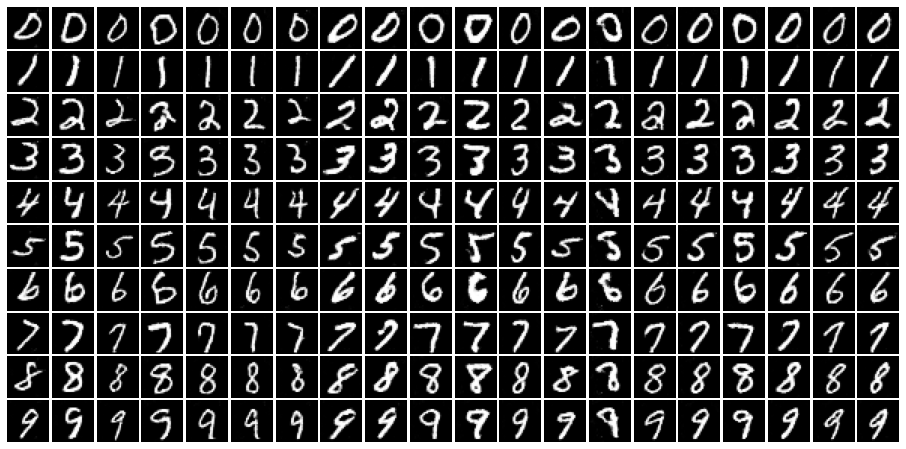

In [14]:
net_g = Generator().to(device)
net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
net_g.eval()
show(net_g)